# Homework 2: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [1]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import os
import xarray as xr

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [2]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = 'C:/Users/rilee/MS 274/Data'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [3]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
ssh92_file = os.path.join(ssh_folder,'Version4','Release4',
                          'interp_monthly','SSHDYN','SSHDYN_1992_01.nc')

ds = xr.open_dataset(ssh92_file)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
ssh_1992 = np.array(ds['SSHDYN'][:])
ds.close()

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
ssh17_file = os.path.join(ssh_folder,'Version4','Release4',
                          'interp_monthly','SSHDYN','SSHDYN_2017_01.nc')

ds = xr.open_dataset(ssh17_file)
ssh_2017 = np.array(ds['SSHDYN'][:])
ds.close()

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

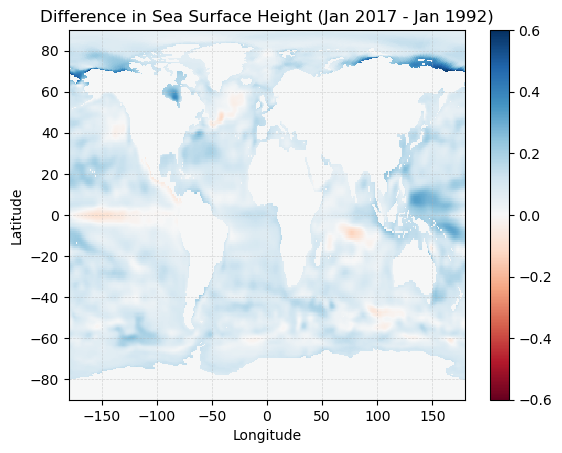

In [4]:
# make a plot of the differences between 2017 and 1992

#find the difference in SSH between the two years
ssh_diff = ssh_2017[0,:,:] - ssh_1992[0,:,:] 
#make plot
fig = plt.figure()

# plot the difference
plt.pcolormesh(longitude,latitude, ssh_diff, cmap="RdBu", vmin=-0.6, vmax=0.6)
#add colorbar
plt.colorbar()

# format the axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Difference in Sea Surface Height (Jan 2017 - Jan 1992)')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()


### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: The largest increases in sea level observed between these two time periods are in the Arctic regions and Western Pacific, which is likely due to sea ice melting. Sea level has fallen in the Indian Ocean, some parts of the North Atlantic, and near the Equator in the Pacific near South America.

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [5]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lon_index = np.argmin(np.abs((-122) - longitude))
lat_index = np.argmin(np.abs((37) - latitude))

Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

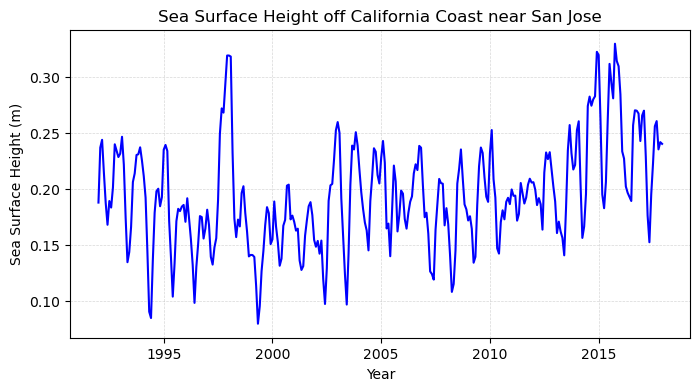

In [6]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
# make a list to contain the file names
file_list = []

# loop through the years
for year in range(1992,2018):
    for month in range(1,13):
        file_list.append('SSHDYN_'+str(year)+'_'+'{:02d}'.format(month)+'.nc')

# make a list to store the SSH values
ssh_values = []

# loop through each file
for i in range(len(file_list)):
    file_name = file_list[i]
    
    # identify path to the data file
    month_file = os.path.join(ssh_folder,'Version4','Release4',
                          'interp_monthly','SSHDYN',file_name)
    
    # read in the data 
    ds = xr.open_dataset(month_file)
    ssh_month = np.array(ds['SSHDYN'][:])
    ds.close()

    # extract SSH and sample the SSH grid at lat and lon indexed above, and add time
    ssh_sj = ssh_month[0, lat_index, lon_index]
    date = 1992 + i/12
    ssh_values.append([date,ssh_sj])
    
# convert list to a numpy array
ssh_values = np.array(ssh_values)

#plot the timeseries
# make a figure
fig = plt.figure(figsize=(8,4))

# plot the temperatures in black
plt.plot(ssh_values[:,0], ssh_values[:,1],"b-")

# format the axes
plt.ylabel('Sea Surface Height (m)')
plt.xlabel('Year')
plt.title('Sea Surface Height off California Coast near San Jose')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

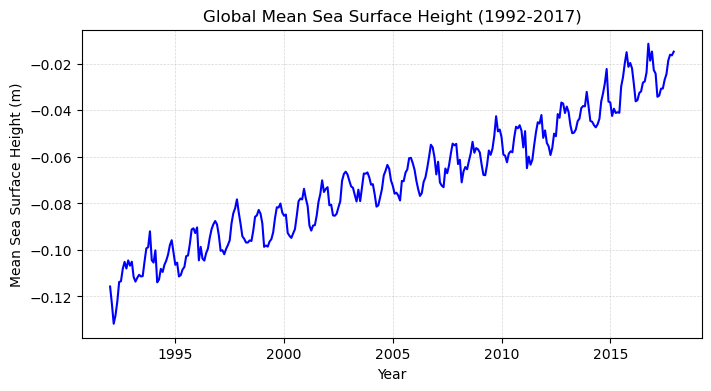

In [7]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
file_list = []

# loop through the years
for year in range(1992,2018):
    for month in range(1,13):
        file_list.append('SSHDYN_'+str(year)+'_'+'{:02d}'.format(month)+'.nc')

# make a list to store the SSH values
global_ssh_list = []

# loop through each file
for i in range(len(file_list)):
    file_name = file_list[i]
    
    # identify path to the data file
    month_file = os.path.join(ssh_folder,'Version4','Release4',
                          'interp_monthly','SSHDYN',file_name)
    
    # read in the data 
    ds = xr.open_dataset(month_file)
    ssh_month = np.array(ds['SSHDYN'][:])
    ds.close()

    #mask out land
    glob_ssh = ssh_month[ssh_month != 0]

    #find means
    global_mean_ssh = np.mean(glob_ssh)

    #add time
    date = 1992 + i/12

    #append
    global_ssh_list.append([date, global_mean_ssh])
    
# convert list to a numpy array
globssh_values = np.array(global_ssh_list)

#plot the timeseries
# make a figure
fig = plt.figure(figsize=(8,4))

# plot the temperatures in black
plt.plot(globssh_values[:,0], globssh_values[:,1],"b-")

# format the axes
plt.ylabel('Mean Sea Surface Height (m)')
plt.xlabel('Year')
plt.title('Global Mean Sea Surface Height (1992-2017)')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [8]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
# compute the line coefficients for the CA timeseries 
ca_line_coefficients = np.polyfit(ssh_values[:,0], ssh_values[:,1], deg=1) 
ca_slope_meters = ca_line_coefficients[0]
ca_trend_mm_per_yr = ca_slope_meters * 1000

#compute the line coefficients for global mean timeseries
glob_line_coefficients = np.polyfit(globssh_values[:,0], globssh_values[:,1], deg=1)
glob_slope_meters = glob_line_coefficients[0]
glob_trend_mm_per_yr = glob_slope_meters * 1000

# print out the statistics in mm/yr for each timeseries
print('California trend:', ca_trend_mm_per_yr, "mm/yr")
print('Global trend:', glob_trend_mm_per_yr, "mm/yr")

California trend: 2.0781058912401367 mm/yr
Global trend: 3.376814580817943 mm/yr


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: The sea level rise in California is rising slowerly locally compared to the global mean rate. This means that on average, we are seeing higher sea surface levels globally compared just in California.

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

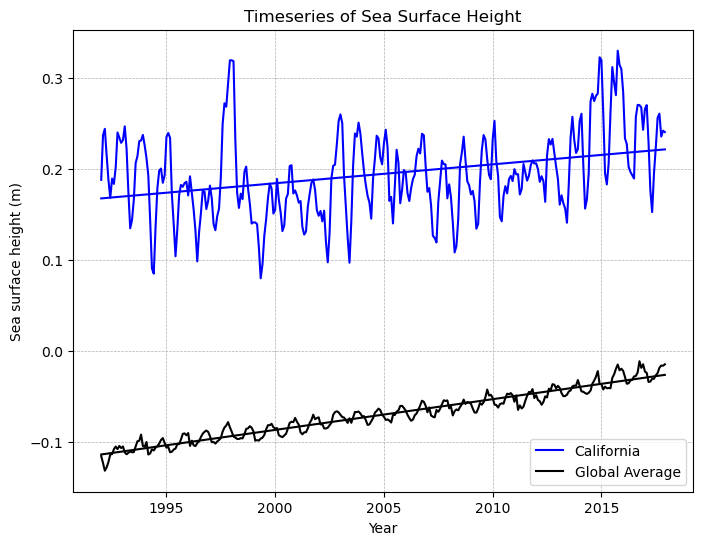

In [9]:
# create your plot here
fig = plt.figure(figsize=(8,6))

# plot the data
plt.plot(ssh_values[:,0], ssh_values[:,1], "b-", label="California")
plt.plot(globssh_values[:,0], globssh_values[:,1], "k-", label='Global Average')

# plot the trend line
plt.plot(ssh_values[:,0], ca_line_coefficients[0] * ssh_values[:,0] + ca_line_coefficients[1], "b-")
plt.plot(globssh_values[:,0], glob_line_coefficients[0] * globssh_values[:,0] + glob_line_coefficients[1], "k-")

plt.title('Timeseries of Sea Surface Height')
plt.ylabel('Sea surface height (m)')
plt.xlabel('Year')
plt.grid(linestyle='--',linewidth=0.5)
plt.legend()
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: The timeseries for California sea surface height is much more variable than the global mean timeseries. Additionally, it's trendline is shallower, indicating that sea surface height is rising slower in California compared to global mean sea surface height. In addition to seasonal variation in sea surface height, there seems to be periods of very variable sea surface height between years in California. The two highest years of sea level in California were in 1998 and 2015/2016. These two periods were El Nino years, in which increased precipation occurs. This phenomenon can be attributed to the high sea surface height seen during those years. 